# Fastai2 Denoising AutoEncoder

In [1]:
%matplotlib inline

In [2]:
from fastai2.vision.all import *
from nbdev.showdoc import *

set_seed(2)

In [3]:
path = untar_data(URLs.MNIST); path

Path('/Users/jeremyblythe/.fastai/data/mnist_png')

In [315]:
class RandNoisyTransform(Transform):
    order = 100 # After Normalize
    def __init__(self, noise_factor = 0.5):
        self.noise_factor = noise_factor

    def __call__(self, b, **kwargs):
        x,y = b
        return x + self.noise_factor * torch.randn(x.shape), y

In [316]:
mnist = DataBlock(blocks = (ImageBlock(cls=PILImageBW),ImageBlock(cls=PILImageBW)),
                  get_items = get_image_files,
                  splitter = GrandparentSplitter(train_name='training', valid_name='testing'),
                  batch_tfms = [RandNoisyTransform()])

In [317]:
data = mnist.dataloaders(path, verbose=True)

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> RandNoisyTransform


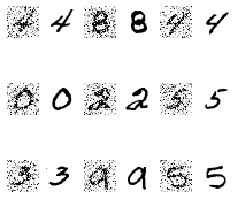

In [318]:
data.show_batch(figsize=(4,4))

In [334]:
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()

        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(32, 16, 3, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2,2),
                                    nn.Conv2d(16, 8, 3, padding=1),
                                    nn.ReLU(inplace=True),
                                    nn.MaxPool2d(2,2))
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(8, 8, 3, stride=2),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(8, 16, 2, stride=2),
                                     nn.ReLU(inplace=True),
                                     nn.ConvTranspose2d(16, 32, 2, stride=2),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(32, 1, 3, padding=1),
                                     nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# initialize the NN
model = ConvDenoiser()
print(model)

ConvDenoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmo

In [335]:
learn = Learner(data, model, loss_func=mse)

In [336]:
learn.summary()

ConvDenoiser (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 28 x 28    320        True      
________________________________________________________________
ReLU                 64 x 32 x 28 x 28    0          False     
________________________________________________________________
MaxPool2d            64 x 32 x 14 x 14    0          False     
________________________________________________________________
Conv2d               64 x 16 x 14 x 14    4,624      True      
________________________________________________________________
ReLU                 64 x 16 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 16 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       1,160      True      
_________________________________________________

In [337]:
learn.fit(30)

epoch,train_loss,valid_loss,time
0,0.035984,0.035094,02:34
1,0.029254,0.028356,02:28
2,0.025192,0.024749,02:27
3,0.023036,0.022665,02:28
4,0.021527,0.021243,02:27
5,0.020928,0.020109,02:28
6,0.020253,0.019667,02:27
7,0.019756,0.019225,02:28
8,0.019405,0.018938,02:26
9,0.019058,0.018996,02:30


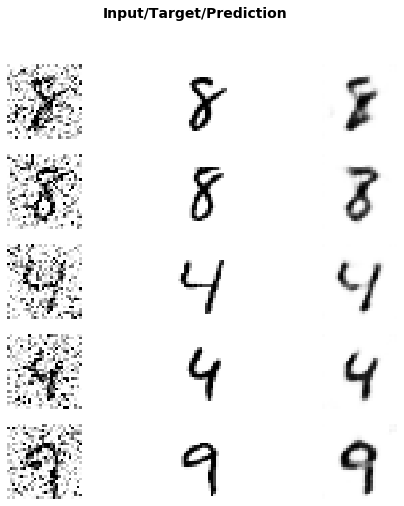

In [338]:
learn.show_results(max_n=6, figsize=(8,8))